<a href="https://colab.research.google.com/github/DDD66218/ML/blob/main/Exploraci%C3%B3n_de_modelos__de_machine_learning_para_clasificacion_binaria_de_voces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploración de modelos para clasificacion binaria de voces

Daniel Fonseca Díaz

---


Pregrado


---


OJO!!!!!!!!!!



 si desea correr el colab desde el principio cargue el dataset de kaggle siguiendo las celdas del colab.

---
Si deseas correrlo sin el dataset de kaggle solo ejecuta "Aqui bajas los datos" para obtener el dataset ya procesado y comienza corriendo el colab desde la celda "Particion de datos"

notas: male 0 female 1

# Aqui bajas los datos

In [72]:
!wget https://github.com/DDD66218/ML/blob/main/features_list.pkl
!wget https://github.com/DDD66218/ML/blob/main/labels.csv

--2024-05-27 23:18:26--  https://github.com/DDD66218/ML/blob/main/features_list.pkl
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘features_list.pkl’

features_list.pkl       [ <=>                ] 143.37K  --.-KB/s    in 0.02s   

2024-05-27 23:18:27 (6.34 MB/s) - ‘features_list.pkl’ saved [146807]

--2024-05-27 23:18:27--  https://github.com/DDD66218/ML/blob/main/labels.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘labels.csv’

labels.csv              [ <=>                ] 276.20K  --.-KB/s    in 0.04s   

2024-05-27 23:18:27 (7.38 MB/s) - ‘labels.csv’ saved [282831]



# aqui se cargan los datos


In [57]:
### Aqui cargamos labels porque el dataframe shuffled_df no esta cargado como variable de entorno

# Lee el archivo CSV y carga los datos en una Serie
serie = pd.read_csv('/content/labels.csv', header=None, index_col=None).squeeze()

# Divide los datos separados por comas en una lista
serie = serie.str.split(',')

# Convierte la lista en una Serie
labels = serie.apply(pd.Series).stack().reset_index(drop=True)

In [52]:
with open('features_list.pkl', 'rb') as archivo:
    features_list = pickle.load(archivo)

# dependencias

In [1]:
!pip install opendatasets
!pip install SpeechRecognition
!pip install PyAudio
!pip install librosa
!pip install ffprobe-python
!pip install ffmpeg-python
!pip install pydub
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for PyAudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyAudio
Failed to build PyAudio
ERROR: Could not build wheels for PyAudio, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.3 MB/s eta 0:00:00


In [2]:
  import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/mozillaorg/common-voice/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dfo21nseca8
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mozillaorg/common-voice


100%|██████████| 12.0G/12.0G [06:24<00:00, 33.6MB/s]


# importaciones

In [5]:
import speech_recognition as sr
import IPython.display as ipd
import os
import pandas as pd
import librosa
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import random
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Wrapper
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from pydub import AudioSegment
import re
import resampy

In [6]:
np.set_printoptions(suppress=True)

# análisis exploratorio de datos

In [7]:
# Leer el archivo CSV y filtrar las columnas necesarias
df = pd.read_csv("/content/common-voice/cv-valid-train.csv", usecols=['filename', 'gender'])

# Eliminar filas con valores NaN en la columna 'gender'
df_cleaned = df.dropna(subset=['gender'])

# Tomar una muestra de 300 filas para cada género y combinarlas en un solo DataFrame
shuffled_df = pd.concat([df_cleaned[df_cleaned['gender'] == 'male'][:600], df_cleaned[df_cleaned['gender'] == 'female'][:600]], ignore_index=True)

# Mezclar el orden de las filas
shuffled_df = shuffled_df.sample(frac=1).reset_index(drop=True)



In [8]:
def remove_path_and_change(df):
  df['filename'] = df['filename'].str.replace('cv-valid-train/', '')
  return df

# Aplicar la función al DataFrame
shuffled_df = remove_path_and_change(shuffled_df)

# conviertiendo los archivos de audio del dataset en un formato apropiado

In [9]:
# VIEJOOOOOOOOOOOOOO Ruta de los audios
TRAIN_PATH = '/content/common-voice/cv-valid-train/cv-valid-train'
OUTPUT_PATH = '/content/common-voice/cv-valid-train-wav/'

# Crear la carpeta de destino si no existe
os.makedirs(OUTPUT_PATH, exist_ok=True)

def convert_to_wav(df, output_path, train_path):
    for file in df['filename']:
        # Leer el archivo MP3
        sound = AudioSegment.from_mp3(os.path.join(train_path, file))

        # Quitar la extensión .mp3 del nombre del archivo
        nombre_sin_extension = re.sub(r'\.mp3$', '', file)

        # Crear el nombre del nuevo archivo con extensión .wav
        new_file = nombre_sin_extension + '.wav'

        # Ruta completa del nuevo archivo en la carpeta de destino
        new_file_path = os.path.join(output_path, new_file)

        # Exportar el archivo a la carpeta de destino con el nombre completo
        sound.export(new_file_path, format='wav')

    return

# Asumiendo que df_cleaned es tu DataFrame con la columna 'filename'
convert_to_wav(shuffled_df, OUTPUT_PATH, TRAIN_PATH)

In [10]:
def change_mp3_to_wav(df):
  df['filename'] = df['filename'].str.replace('mp3', 'wav', regex=False)
  return df

# Aplicar la función al DataFrame
shuffled_df = change_mp3_to_wav(shuffled_df)

# extrayendo las caracteristicas de los audios para el entrenamiento posterior de los modelos.

In [11]:
data_dir = '/content/common-voice/cv-valid-train-wav'

# Función para extraer las características de los archivos de audio
def extract_features(row, data_dir):
    # Establece el nombre de la ruta a donde están los archivos de audio en mi computadora
    file_name = os.path.join(os.path.abspath(data_dir), row['filename'])

    # Carga el archivo de audio como una serie de tiempo de coma flotante y asigna la frecuencia de muestreo predeterminada
    try:
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return None

    # Genera Mel-frequency cepstral coefficients (MFCCs) de la serie de tiempo
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)

    # Genera una transformada de Fourier a corto plazo (STFT) para usar en chroma_stft

    stft = np.abs(librosa.stft(y=X,n_fft=512))

    # Calcula un cromagrama a partir de una forma de onda o espectrograma de potencia
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    # Calcula un espectrograma de mel-scaled
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)

    # Calcula el contraste espectral
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)

    # Calcula las características del centroide tonal (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)

    # Agrega las clases de cada archivo como una etiqueta al final
    label = row['gender']

    # Devuelve todos los indicadores más el target
    return mfccs, chroma, mel, contrast, tonnetz, label

# Aplicar la función extract_features a cada fila del DataFrame
features_list = shuffled_df.apply(lambda row: extract_features(row, data_dir), axis=1)

# Filtrar los resultados None (en caso de errores de carga)
features_list = [f for f in features_list if f is not None]

# Crear un DataFrame con las características extraídas
features_df = pd.DataFrame(features_list, columns=['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz', 'label'])

# Mostrar el DataFrame con las características
print(features_df)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=604
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=836
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=877
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=753
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=902
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=778
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: 

                                                  mfccs  \
0     [-386.14996, 100.47823, 7.786498, 17.727417, -...   
1     [-371.95956, 64.56132, -43.588997, 33.62543, -...   
2     [-442.21582, 92.431854, -39.001766, 31.046305,...   
3     [-479.1466, 126.74258, -26.622208, 28.333714, ...   
4     [-325.21487, 74.24136, -17.24957, 33.459763, -...   
...                                                 ...   
1195  [-387.36145, 56.861713, -11.236079, 12.311972,...   
1196  [-400.97995, 75.91675, -20.334965, -2.1718917,...   
1197  [-325.14313, 99.957695, 2.163007, 16.400331, -...   
1198  [-402.49857, 91.57344, 4.4922037, 34.61576, -2...   
1199  [-567.725, 95.07073, -25.576471, 38.639015, -3...   

                                                 chroma  \
0     [0.4315635, 0.49073178, 0.6607009, 0.5990711, ...   
1     [0.48357618, 0.4515858, 0.47585386, 0.5654676,...   
2     [0.7198578, 0.70452756, 0.6998938, 0.69156814,...   
3     [0.64711934, 0.60551214, 0.59612477, 0.6111411...

In [56]:
## labels que vamos a usar
labels=shuffled_df.gender

# aqui se exportó la salida de la extracción de datos para un uso más comodo al querer correr este colab.

In [51]:
import pickle

# Guardar el objeto en un archivo
with open('features_list.pkl', 'wb') as archivo:
    pickle.dump(features_list, archivo)

# partición de datos

In [54]:
#De la lista generada construimos un array de datos, el cual ingresará a nuestra red neuronal

features = []

for i in range(0, len(features_list)):

    features.append(np.concatenate((features_list[i][0], features_list[i][1],

                features_list[i][2], features_list[i][3],

                features_list[i][4]), axis=0))



##--El largo del archivo debe ser igual al del df y de los labels

print(len(shuffled_df))
print(len(features))

1200
1200


In [58]:
##--separamos los valores X y los valores Y
X = np.array(features)
y = np.array(labels)

# recodificamos el valor Y a un tipo categórico
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y),2)

#revisamos los tamaños de los arrays de X e Y: (a:b); a representa total de filas y b total de columnas

print(X.shape)
print(y.shape)

(1200, 193)
(1200, 2)


In [59]:
porcentaje_entrenamiento = 0.6
porcentaje_validacion = 0.2
porcentaje_prueba = 0.2

# División de entrenamiento
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-porcentaje_entrenamiento, random_state=42)

# División de validación y prueba
proporcion_restante = porcentaje_validacion / (porcentaje_validacion + porcentaje_prueba)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=proporcion_restante, random_state=42)

## ML

# LogisticRegression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression: 0.9041666666666667
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       120
           1       0.90      0.91      0.90       120

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240



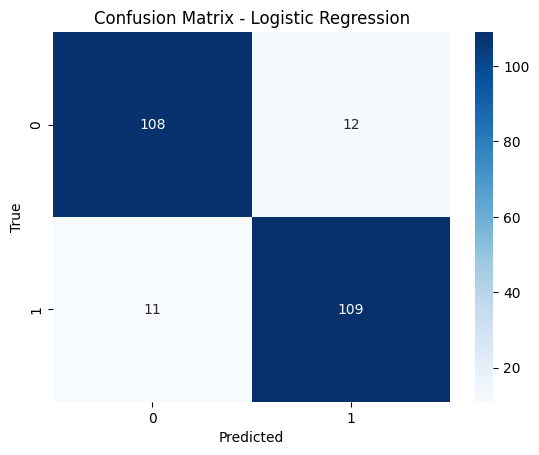

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_regression(X_train, X_test, y_train, y_test):
    model_lr = LogisticRegression()
    model_lr.fit(X_train, y_train.argmax(axis=1))

    y_pred_lr = model_lr.predict(X_test)
    accuracy_lr = accuracy_score(y_test.argmax(axis=1), y_pred_lr)
    print(f'Accuracy Logistic Regression: {accuracy_lr}')
    print(classification_report(y_test.argmax(axis=1), y_pred_lr))

    # Visualización de la matriz de confusión
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_lr)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Ejecutar el método
logistic_regression(X_train, X_test, y_train, y_test)


# SVC

Accuracy SVM: 0.775
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       120
           1       0.82      0.71      0.76       120

    accuracy                           0.78       240
   macro avg       0.78      0.78      0.77       240
weighted avg       0.78      0.78      0.77       240



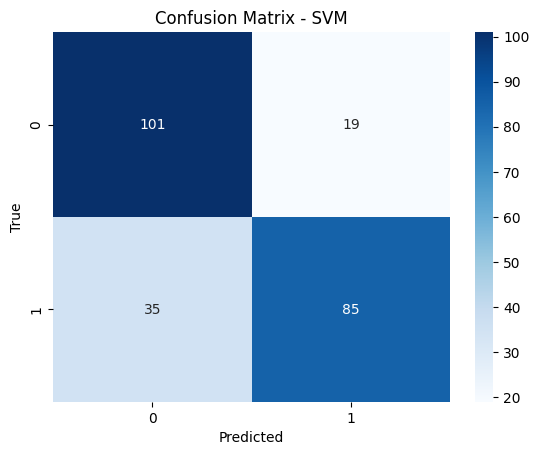

In [65]:
from sklearn.svm import SVC

def support_vector_machine(X_train, X_test, y_train, y_test):
    model_svm = SVC()
    model_svm.fit(X_train, y_train.argmax(axis=1))

    y_pred_svm = model_svm.predict(X_test)
    accuracy_svm = accuracy_score(y_test.argmax(axis=1), y_pred_svm)
    print(f'Accuracy SVM: {accuracy_svm}')
    print(classification_report(y_test.argmax(axis=1), y_pred_svm))

    # Visualización de la matriz de confusión
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_svm)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - SVM")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Ejecutar el método
support_vector_machine(X_train, X_test, y_train, y_test)


# KNeighborsClassifier

In [66]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenamiento del modelo
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train.argmax(axis=1))

# Evaluación del modelo
y_pred_knn = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test.argmax(axis=1), y_pred_knn)
print(f'Accuracy K-NN: {accuracy_knn}')


Accuracy K-NN: 0.7291666666666666


# DecisionTreeClassifier

Accuracy Decision Tree: 0.8458333333333333
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       120
           1       0.85      0.83      0.84       120

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



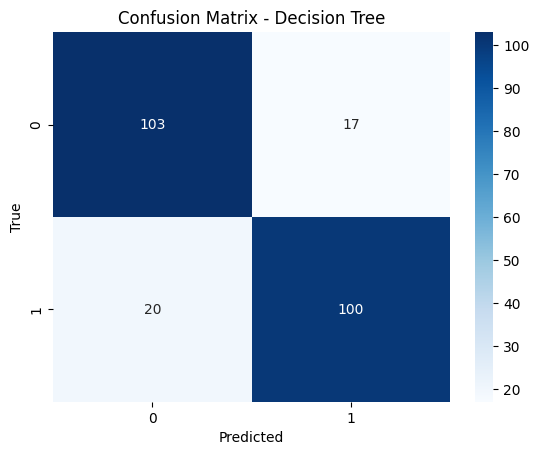

In [67]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, X_test, y_train, y_test):
    model_dt = DecisionTreeClassifier()
    model_dt.fit(X_train, y_train.argmax(axis=1))

    y_pred_dt = model_dt.predict(X_test)
    accuracy_dt = accuracy_score(y_test.argmax(axis=1), y_pred_dt)
    print(f'Accuracy Decision Tree: {accuracy_dt}')
    print(classification_report(y_test.argmax(axis=1), y_pred_dt))

    # Visualización de la matriz de confusión
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_dt)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Decision Tree")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Ejecutar el método
decision_tree(X_train, X_test, y_train, y_test)


# RandomForestClassifier

Accuracy Random Forest: 0.9125
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       120
           1       0.92      0.91      0.91       120

    accuracy                           0.91       240
   macro avg       0.91      0.91      0.91       240
weighted avg       0.91      0.91      0.91       240



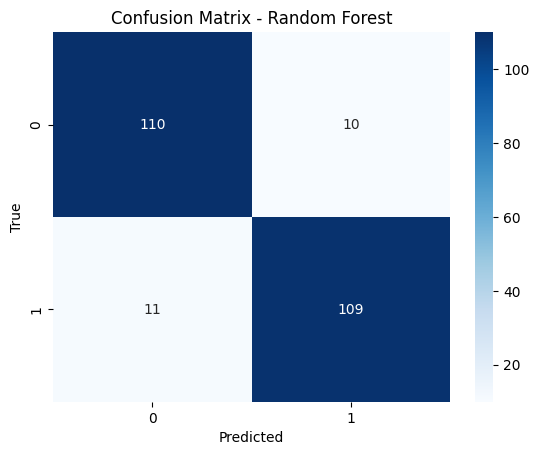

In [68]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(X_train, X_test, y_train, y_test):
    model_rf = RandomForestClassifier()
    model_rf.fit(X_train, y_train.argmax(axis=1))

    y_pred_rf = model_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test.argmax(axis=1), y_pred_rf)
    print(f'Accuracy Random Forest: {accuracy_rf}')
    print(classification_report(y_test.argmax(axis=1), y_pred_rf))

    # Visualización de la matriz de confusión
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_rf)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Random Forest")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Ejecutar el método
random_forest(X_train, X_test, y_train, y_test)



# xgb

Accuracy XGBoost: 0.925
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       120
           1       0.93      0.93      0.93       120

    accuracy                           0.93       240
   macro avg       0.93      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240



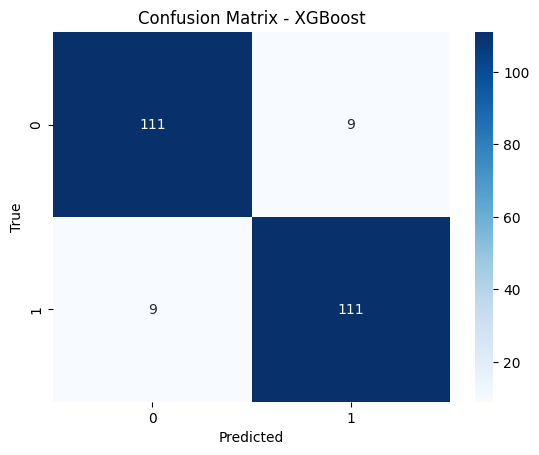

In [69]:
import xgboost as xgb

def xgboost_model(X_train, X_test, y_train, y_test):
    model_xgb = xgb.XGBClassifier()
    model_xgb.fit(X_train, y_train.argmax(axis=1))

    y_pred_xgb = model_xgb.predict(X_test)
    accuracy_xgb = accuracy_score(y_test.argmax(axis=1), y_pred_xgb)
    print(f'Accuracy XGBoost: {accuracy_xgb}')
    print(classification_report(y_test.argmax(axis=1), y_pred_xgb))

    # Visualización de la matriz de confusión
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_xgb)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - XGBoost")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Ejecutar el método
xgboost_model(X_train, X_test, y_train, y_test)



# CNNs

1

Epoch 1/50
144/144 [==============================] - 2s 5ms/step - loss: 1.9337 - accuracy: 0.6097 - val_loss: 0.6321 - val_accuracy: 0.6458
Epoch 2/50
144/144 [==============================] - 1s 4ms/step - loss: 0.5218 - accuracy: 0.7403 - val_loss: 0.4290 - val_accuracy: 0.8083
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.3981 - accuracy: 0.8389 - val_loss: 0.4116 - val_accuracy: 0.8458
Epoch 4/50
144/144 [==============================] - 1s 6ms/step - loss: 0.3476 - accuracy: 0.8556 - val_loss: 0.3731 - val_accuracy: 0.8583
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.3244 - accuracy: 0.8722 - val_loss: 0.3881 - val_accuracy: 0.8250
Epoch 6/50
144/144 [==============================] - 1s 6ms/step - loss: 0.3060 - accuracy: 0.8792 - val_loss: 0.3347 - val_accuracy: 0.8708
Epoch 7/50
144/144 [==============================] - 1s 5ms/step - loss: 0.3069 - accuracy: 0.8653 - val_loss: 0.3588 - val_accuracy: 0.8375
Epoch 

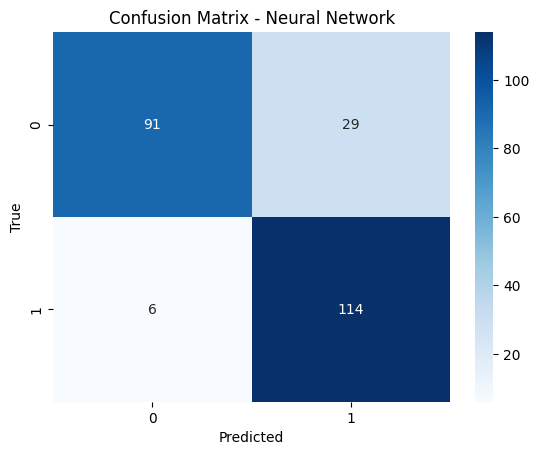

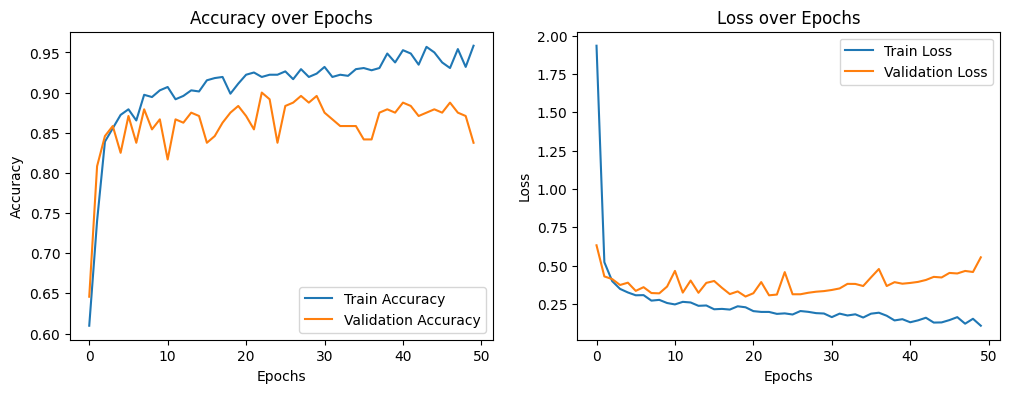

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def neural_network(X_train, X_test, y_train, y_test, X_val, y_val):
    # Definición del modelo
    model_nn = Sequential()
    model_nn.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
    model_nn.add(Dense(8, activation='relu'))
    model_nn.add(Dense(2, activation='softmax'))

    # Compilación del modelo
    model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrenamiento del modelo
    history = model_nn.fit(X_train, y_train, epochs=50, batch_size=5, validation_data=(X_val, y_val), verbose=1)

    # Evaluación del modelo
    loss, accuracy_nn = model_nn.evaluate(X_test, y_test)
    print(f'Accuracy Neural Network: {accuracy_nn}')

    # Predicciones
    y_pred_nn = model_nn.predict(X_test).argmax(axis=1)
    print(classification_report(y_test.argmax(axis=1), y_pred_nn))

    # Visualización de la matriz de confusión
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_nn)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Neural Network")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Visualización de la precisión y la pérdida durante el entrenamiento
    plt.figure(figsize=(12, 4))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Ejecutar el método
neural_network(X_train, X_test, y_train, y_test, X_val, y_val)


2

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Definir la arquitectura del modelo CNN
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # Para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=60, validation_split=0.2)

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)


Epoch 1/100
10/10 [==============================] - 7s 81ms/step - loss: 1.0688 - accuracy: 0.6250 - val_loss: 0.5099 - val_accuracy: 0.7778
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5121 - accuracy: 0.7708 - val_loss: 0.4763 - val_accuracy: 0.7639
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4200 - accuracy: 0.8212 - val_loss: 0.4197 - val_accuracy: 0.8194
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4200 - accuracy: 0.8160 - val_loss: 0.3665 - val_accuracy: 0.8333
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3468 - accuracy: 0.8594 - val_loss: 0.3835 - val_accuracy: 0.8403
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3116 - accuracy: 0.8646 - val_loss: 0.3689 - val_accuracy: 0.8542
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 0.3052 - accuracy: 0.8837 - val_loss: 0.3305 - val_accuracy: 0.8472
Epoch 

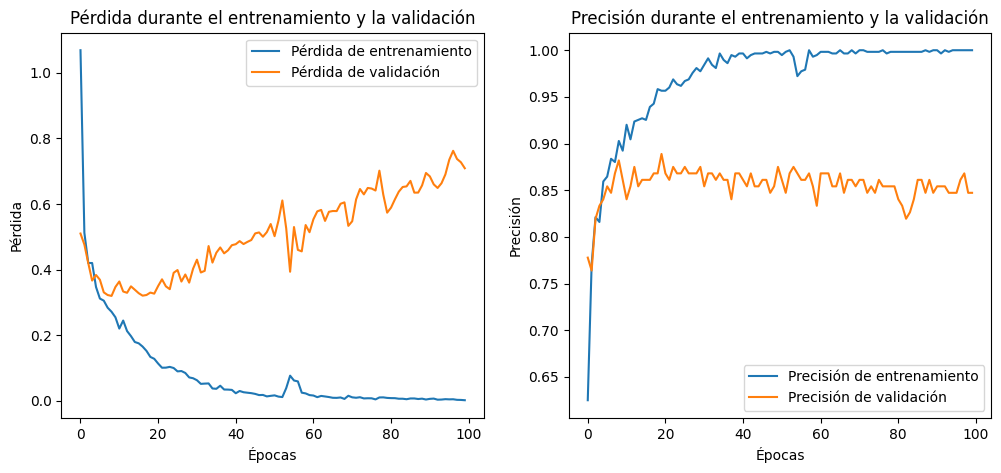

In [61]:
import matplotlib.pyplot as plt

# Función para graficar la pérdida y la precisión
def plot_history(history):
    # Pérdida
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida durante el entrenamiento y la validación')

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión durante el entrenamiento y la validación')

    plt.show()

# Llamar a la función para graficar
plot_history(history)


3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Definir la arquitectura del modelo CNN
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # Para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)


Epoch 1/50
18/18 [==============================] - 3s 26ms/step - loss: 0.7839 - accuracy: 0.6406 - val_loss: 0.4704 - val_accuracy: 0.8681
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.4524 - accuracy: 0.8160 - val_loss: 0.4960 - val_accuracy: 0.7778
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 0.4082 - accuracy: 0.8368 - val_loss: 0.4074 - val_accuracy: 0.8264
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.3337 - accuracy: 0.8542 - val_loss: 0.3451 - val_accuracy: 0.8819
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.2767 - accuracy: 0.8837 - val_loss: 0.3477 - val_accuracy: 0.8958
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.1984 - accuracy: 0.9236 - val_loss: 0.3644 - val_accuracy: 0.8611
Epoch 7/50
18/18 [==============================] - 0s 6ms/step - loss: 0.2124 - accuracy: 0.9184 - val_loss: 0.3307 - val_accuracy: 0.8889
Epoch 8/50
18/18 [=

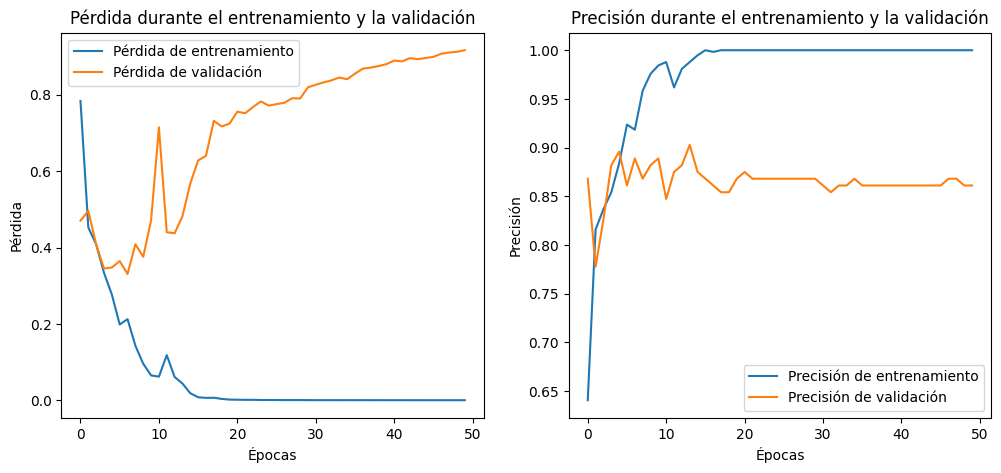

In [ ]:
def plot_history(history):
    # Pérdida
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida durante el entrenamiento y la validación')

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión durante el entrenamiento y la validación')

    plt.show()

# Llamar a la función para graficar
plot_history(history)

4

In [ ]:
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # Para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con regularización y datos aumentados
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

Epoch 1/50
18/18 [==============================] - 2s 21ms/step - loss: 0.8377 - accuracy: 0.6493 - val_loss: 0.4875 - val_accuracy: 0.8542
Epoch 2/50
18/18 [==============================] - 0s 9ms/step - loss: 0.4316 - accuracy: 0.8229 - val_loss: 0.4267 - val_accuracy: 0.8056
Epoch 3/50
18/18 [==============================] - 0s 8ms/step - loss: 0.4346 - accuracy: 0.8142 - val_loss: 0.3873 - val_accuracy: 0.8819
Epoch 4/50
18/18 [==============================] - 0s 9ms/step - loss: 0.3345 - accuracy: 0.8715 - val_loss: 0.3593 - val_accuracy: 0.8819
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.2643 - accuracy: 0.9062 - val_loss: 0.3718 - val_accuracy: 0.8819
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.2677 - accuracy: 0.8976 - val_loss: 0.3478 - val_accuracy: 0.8681
Epoch 7/50
18/18 [==============================] - 0s 7ms/step - loss: 0.2217 - accuracy: 0.9062 - val_loss: 0.4163 - val_accuracy: 0.8611
Epoch 8/50
18/18 [=

5

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Model 1
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

# Compila el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Entrena el modelo
history = model.fit(X_train, y_train, epochs=400, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])
# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

Epoch 1/400
23/23 [==============================] - 5s 37ms/step - loss: 1.3878 - accuracy: 0.6611 - val_loss: 0.8561 - val_accuracy: 0.8250
Epoch 2/400
23/23 [==============================] - 0s 12ms/step - loss: 0.7522 - accuracy: 0.8306 - val_loss: 0.7143 - val_accuracy: 0.8292
Epoch 3/400
23/23 [==============================] - 0s 8ms/step - loss: 0.6222 - accuracy: 0.8583 - val_loss: 0.6247 - val_accuracy: 0.8458
Epoch 4/400
23/23 [==============================] - 0s 8ms/step - loss: 0.5060 - accuracy: 0.8931 - val_loss: 0.5823 - val_accuracy: 0.8500
Epoch 5/400
23/23 [==============================] - 0s 8ms/step - loss: 0.4379 - accuracy: 0.9069 - val_loss: 0.5332 - val_accuracy: 0.8875
Epoch 6/400
23/23 [==============================] - 0s 8ms/step - loss: 0.3541 - accuracy: 0.9264 - val_loss: 0.5136 - val_accuracy: 0.8792
Epoch 7/400
23/23 [==============================] - 0s 7ms/step - loss: 0.3066 - accuracy: 0.9472 - val_loss: 0.5315 - val_accuracy: 0.8667
Epoch 8/400

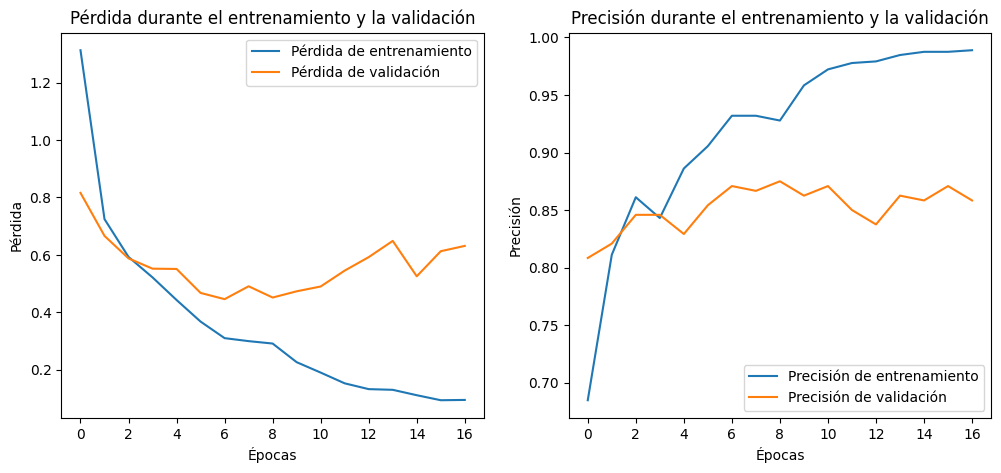

In [ ]:
def plot_history(history):
    # Pérdida
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida durante el entrenamiento y la validación')

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión durante el entrenamiento y la validación')

    plt.show()

# Llamar a la función para graficar
plot_history(history)